In [1]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import fiona
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import box
import matplotlib.patches as patches
from functions import *

### Obtain water stations

In [11]:
dir_path = '../data/external/water_stations_data/water_temp'
stations_meta_wt = pd.read_excel('../data/external/Stationsliste_HydrowebSAM_EN_july2023.xlsx',skiprows=range(0,4))
stations_meta_wt.rename(columns={'Station number': 'Stationsnummer'}, inplace=True)
stations_meta_wt.drop_duplicates(subset = ['Stationsnummer'], inplace=True)

In [17]:
wt_stations=set()
new_df = pd.DataFrame()
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file), delimiter=';', encoding='latin1', skiprows=range(0,8))
        st_number = df.Stationsnummer.unique()
        st_number_str = st_number[0]
        
        if len(st_number) > 1:
            i = 1
            while st_number_str == 'Stationsnummer' or np.isnan(float(st_number_str)):
                st_number_str = st_number[i]
                i+=1
        if st_number_str in stations_meta_wt['Stationsnummer'].values:
            
            wt_stations.add(st_number_str)
wt_stations

{2009,
 2011,
 2016,
 2018,
 2019,
 2029,
 2030,
 2033,
 2034,
 2044,
 2056,
 2068,
 2070,
 2084,
 2085,
 2091,
 2104,
 2106,
 2109,
 2112,
 2113,
 2126,
 2130,
 2135,
 2139,
 2143,
 2150,
 2152,
 2159,
 2161,
 2167,
 2170,
 2174,
 2179,
 2181,
 2205,
 2210,
 2232,
 2243,
 2256,
 2269,
 2276,
 2282,
 2288,
 2307,
 2308,
 2327,
 2343,
 2347,
 2351,
 2356,
 2366,
 2369,
 2372,
 2374,
 2375,
 2386,
 2392,
 2410,
 2414,
 2415,
 2432,
 2433,
 2457,
 2462,
 2467,
 2473,
 2481,
 2485,
 2493,
 2500,
 2604,
 2606,
 2608,
 2609,
 2612,
 2613,
 2617,
 2623,
 2634,
 2635}

### Obtain georeference about stations that have data

In [20]:
dir_path = '../data/external/water_stations_data/discharge'
stations_meta = pd.read_excel('../data/external/Stationsliste_HydrowebSAM_EN_july2023.xlsx',skiprows=range(0,4))
stations_meta.rename(columns={'Station number': 'Stationsnummer'}, inplace=True)
stations_meta.drop_duplicates(subset = ['Stationsnummer'], inplace=True)

In [28]:
len(wt_stations)

81

In [34]:
stations_ds={}
new_df = pd.DataFrame()
c=0
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file), delimiter=';', encoding='latin1', skiprows=range(0,8))
        st_number = df.Stationsnummer.unique()
        st_number_str = st_number[0]
        
        if len(st_number) > 1:
            i = 1
            while st_number_str == 'Stationsnummer' or np.isnan(float(st_number_str)):
                st_number_str = st_number[i]
                i+=1
        print(st_number_str, st_number)
        if st_number_str in stations_meta['Stationsnummer'].values and st_number_str in wt_stations:
            new_df = pd.concat([new_df,stations_meta[stations_meta['Stationsnummer']==st_number_str]])
        
            print('hei',c)
            d = "2013-03-01"
            df = df[df.Zeitstempel >= d]
            stations_ds[st_number_str] = df
            c+=1
            

2403 [2403]
2620 [2620]
2185 [2185]
2416 [2416]
2462 [2462]
hei 0
2268 [2268]
2016 [2016]
hei 1
2263 [2263]
2087 [2087]
2327 [2327]
hei 2
2333 [2333]
2084 [2084]
hei 3
155 [155]
2412 [2412]
352 [352]
2447 [2447]
2387 [2387]
2156 [2156]
2646 [2646]
2067 [2067]
2461 [2461]
2151 [2151]
2239 [2239]
2053 [2053]
2091 [2091]
hei 4
2469 [2469]
2418 [2418]
2640 [2640]
2319 ['2319' nan 'Stationsnummer']
2187 [2187]
2351 [2351]
hei 5
2135 [2135]
hei 6
2605 [2605]
2079 [2079]
2034 [2034]
hei 7
2112 [2112]
hei 8
2300 [2300]
2488 [2488]
2288 [2288]
hei 9
2141 [2141]
2625 [2625]
491 [491]
2477 [2477]
185 [185]
2374 [2374]
hei 10
2343 [2343]
hei 11
2494 [2494]
2485 [2485]
hei 12
2364 [2364]
2420 [2420]
2347 [2347]
hei 13
2056 [2056]
hei 14
2309 [2309]
2063 [2063]
2219 [2219]
2262 [2262]
2086 [2086]
2639 [2639]
2607 [2607]
2011 [2011]
hei 15
2499 [2499]
2446 [2446]
2033 [2033]
hei 16
2342 [2342]
2176 [2176]
2613 [2613]
hei 17
2487 [2487]
2232 [2232]
hei 18
403 [403]
2386 [2386]
hei 19
2106 [2106]
hei 2

In [30]:
len(stations_ds)

76

### Obtain grid cells sorrounding every station

In [35]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

<Axes: >

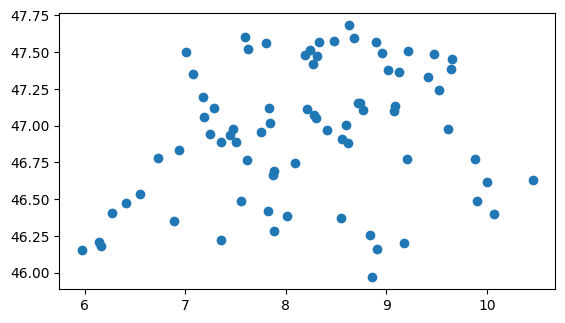

In [36]:
gdf.plot()

EPSG:4326


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


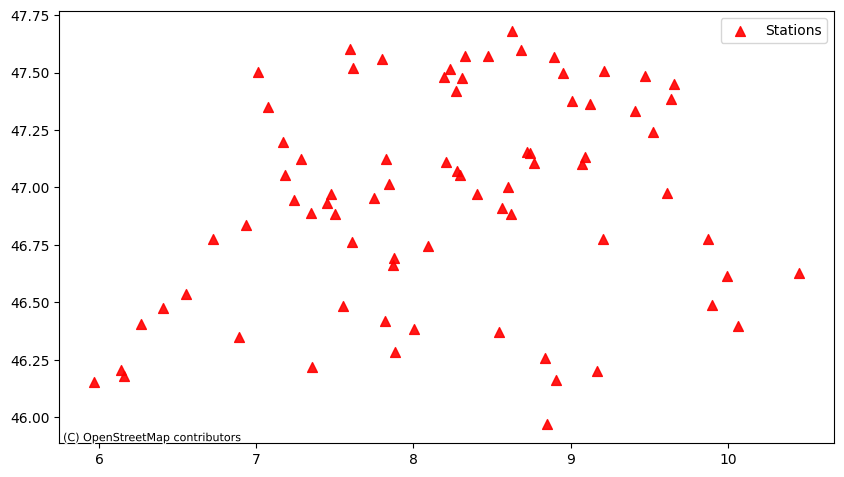

In [37]:
import contextily as ctx
# Leer el shapefile y transformar a EPSG:4326
gdf2 = gpd.read_file('../data/external/shp/Switzerland_shapefile/ch_1km.shp')
gdf2 = gdf2.to_crs("EPSG:2056")
print(gdf.crs)

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 10))

# Ploteo de los puntos de `gdf`
gdf.plot(ax=ax, color="red", marker="^", markersize=50, alpha=0.9, label="Stations")

#gdf2.boundary.plot(ax=ax, edgecolor = 'blue', label="Boundary of gdf2")


# Añadir mapa base (opcional)
ctx.add_basemap(ax, crs=gdf2.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Mostrar la leyenda y el gráfico
ax.legend()
plt.show()

#### Create a shp for each cell

In [38]:
disch_ds = pd.DataFrame(index = stations_ds[2161].Zeitstempel,columns = range(1,len(gdf)+1))

In [39]:
disch_ds

,1,2,3,4,5,6,7,8,9,10,...,67,68,69,70,71,72,73,74,75,76
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Change the CRS to a projected coordinate system (e.g., UTM appropriate for your region)
gdf = gdf.to_crs("EPSG:32633")  # Make sure to use the correct CRS for your region

# Define the buffer size in meters (10x10 km = 5000 m in each direction from the center point)
buffer_size = 6400

# Create a folder to store the shapefiles if it doesn't exist
output_folder = "../data/external/shp/cells"
os.makedirs(output_folder, exist_ok=True)

cell_data = pd.DataFrame(columns=["Cell", "Latitude", "Longitude"])

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])
            
    except:
        print('Not this river')
    



Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


In [41]:
c=1
for idx, point in gdf.iterrows():
    try:
        station_number = point.Stationsnummer
        station_data = stations_ds[station_number]
        disch_ds[c] = list(station_data.Wert.values)

    except Exception as e:
        print(e)
        print(station_number,c, len(list(station_data.Wert.values)))
    c+=1

Length of values (136) does not match length of index (139)
2351 6 136


In [42]:
disch_ds

,1,2,3,4,5,6,7,8,9,10,...,67,68,69,70,71,72,73,74,75,76
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,3.834,241.330,0.370,7.524,789.141,NaN,61.336,10.462,2.540,278.162,...,77.258,251.300,10.027,1.997,159.477,101.443,387.390,105.679,12.149,79.588
2013-04-01 00:00:00,13.225,494.202,1.263,25.170,1242.046,NaN,146.108,14.393,5.024,320.034,...,104.718,412.565,10.138,1.775,366.584,141.716,732.260,226.698,27.070,149.656
2013-05-01 00:00:00,34.581,481.324,2.839,39.725,1534.415,NaN,203.023,10.223,5.075,521.190,...,161.314,496.318,12.847,1.947,378.951,250.523,868.901,291.301,22.402,237.434
2013-06-01 00:00:00,49.038,555.743,4.844,53.951,2078.567,NaN,263.358,8.535,8.664,779.648,...,220.030,547.048,22.801,4.798,435.299,337.491,1120.716,339.567,25.792,332.866
2013-07-01 00:00:00,49.649,328.907,3.820,28.298,1278.919,NaN,188.776,3.332,2.165,555.155,...,119.553,498.051,10.907,0.708,266.880,337.819,644.033,224.320,7.271,203.237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,40.826,414.496,3.753,38.421,1409.133,NaN,206.337,6.453,5.990,498.208,...,133.785,382.467,13.655,1.995,324.285,260.007,769.702,237.402,21.262,211.573
2024-06-01 00:00:00,74.990,529.848,6.792,56.341,2234.300,NaN,289.505,7.493,9.641,893.374,...,233.992,610.775,19.860,3.494,412.651,457.059,1151.792,336.151,22.075,341.667
2024-07-01 00:00:00,66.826,412.620,4.972,27.925,1706.039,NaN,263.186,4.156,6.010,789.944,...,150.107,662.264,13.512,1.393,336.097,475.067,820.925,284.955,15.027,244.022


### Check if river and cell shp are the same

In [44]:
dirr='../data/raw/disch'
os.makedirs(dirr,exist_ok=True)
disch_ds.to_csv(f'{dirr}/discharge.csv',index=True)
#cell_data.to_csv(f'{dirr}/cell_coordinates_oficial.csv',index=False)
pd.read_csv(f'{dirr}/discharge.csv', index_col=0)

,1,2,3,4,5,6,7,8,9,10,...,67,68,69,70,71,72,73,74,75,76
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,3.834,241.330,0.370,7.524,789.141,NaN,61.336,10.462,2.540,278.162,...,77.258,251.300,10.027,1.997,159.477,101.443,387.390,105.679,12.149,79.588
2013-04-01 00:00:00,13.225,494.202,1.263,25.170,1242.046,NaN,146.108,14.393,5.024,320.034,...,104.718,412.565,10.138,1.775,366.584,141.716,732.260,226.698,27.070,149.656
2013-05-01 00:00:00,34.581,481.324,2.839,39.725,1534.415,NaN,203.023,10.223,5.075,521.190,...,161.314,496.318,12.847,1.947,378.951,250.523,868.901,291.301,22.402,237.434
2013-06-01 00:00:00,49.038,555.743,4.844,53.951,2078.567,NaN,263.358,8.535,8.664,779.648,...,220.030,547.048,22.801,4.798,435.299,337.491,1120.716,339.567,25.792,332.866
2013-07-01 00:00:00,49.649,328.907,3.820,28.298,1278.919,NaN,188.776,3.332,2.165,555.155,...,119.553,498.051,10.907,0.708,266.880,337.819,644.033,224.320,7.271,203.237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,40.826,414.496,3.753,38.421,1409.133,NaN,206.337,6.453,5.990,498.208,...,133.785,382.467,13.655,1.995,324.285,260.007,769.702,237.402,21.262,211.573
2024-06-01 00:00:00,74.990,529.848,6.792,56.341,2234.300,NaN,289.505,7.493,9.641,893.374,...,233.992,610.775,19.860,3.494,412.651,457.059,1151.792,336.151,22.075,341.667
2024-07-01 00:00:00,66.826,412.620,4.972,27.925,1706.039,NaN,263.186,4.156,6.010,789.944,...,150.107,662.264,13.512,1.393,336.097,475.067,820.925,284.955,15.027,244.022


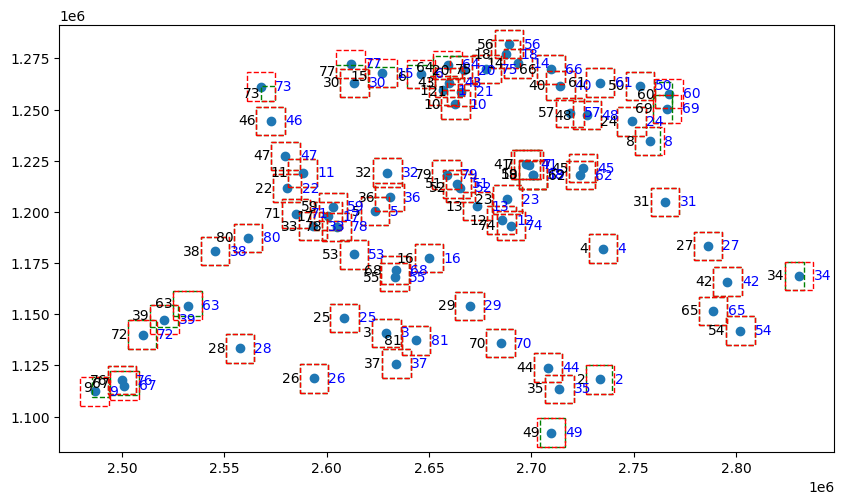

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(ax=ax)
folder = '../data/external/shp/river_cells_oficial'
folder_cells= '../data/external/shp/cells'#_10x10km'
for i in range(1, 82):
    try:
        # Cargar el shapefile de la celda expandida
        cell = os.path.join(folder, f'station_cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="green",
            facecolor="none",
            linestyle="--"
        )
        ax.add_patch(expanded_rect)
        text_x = expanded_bbox[0] - 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="black", fontsize=10, ha="right", va="center")
    
    
        cell = os.path.join(folder_cells, f'cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="red",
            facecolor="none",
            linestyle="--"
        )
        text_x = expanded_bbox[2] + 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="blue", fontsize=10, ha="left", va="center")
    
        ax.add_patch(expanded_rect)
    except:
        pass

### Other visualizations

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(ax=ax)
folder = '../data/external/shp/river_cells_oficial'
folder_cells= '../data/external/shp/cells'#_10x10km'
for i in range(1, 82):
    try:
        # Cargar el shapefile de la celda expandida
        cell = os.path.join(folder, f'station_cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="green",
            facecolor="none",
            linestyle="--"
        )
        ax.add_patch(expanded_rect)
        text_x = expanded_bbox[0] - 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="black", fontsize=10, ha="right", va="center")
    
    
        cell = os.path.join(folder_cells, f'cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="red",
            facecolor="none",
            linestyle="--"
        )
        text_x = expanded_bbox[2] + 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="blue", fontsize=10, ha="left", va="center")
    
        ax.add_patch(expanded_rect)
    except:
        pass

In [ ]:
a=gpd.read_file(os.path.join(output_folder,'cell_1.shp'))
a.plot()
a.crs

#### Plot all cells

In [ ]:
gdf = gdf.to_crs("EPSG:32633")
buffer_size = 5000  # 10x10 km significa 5 km de radio en cada dirección desde el centro

# Función para crear una celda cuadrada alrededor de cada punto
def create_square(point, size):
    x, y = point.x, point.y
    return box(x - size, y - size, x + size, y + size)

# Aplicamos la función a cada punto en el GeoDataFrame
gdf['geometry'] = gdf.geometry.apply(lambda point: create_square(point, buffer_size))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(color='none')

### Comparison to old cells

In [ ]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

In [ ]:
gdf2 = gpd.read_file('../data/external/shp/Switzerland_shapefile')
gdf2 = gdf2.to_crs("EPSG:4326")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf2.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=1, label='Preprocessed Cells')
gdf.plot(ax=ax)
